In [7]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [3]:
train_dir = './aclImdb/train'
test_dir = './aclImdb/test'

data_train = load_files(train_dir, categories=['pos','neg'], shuffle=True, encoding='utf-8')
data_test = load_files(test_dir, categories=['pos','neg'], shuffle=True, encoding='utf-8')

X_train, y_train = data_train.data, data_train.target
X_test, y_test = data_test.data, data_test.target

# Model 1: Naive Bayes

In [ ]:
nb_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('nb', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
nb_preds = nb_pipeline.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))

Naive Bayes Accuracy: 0.8652
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     12500
           1       0.87      0.86      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



# Model 2: Logistic Regression

In [5]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=2000))
])

lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

Logistic Regression Accuracy: 0.8956
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     12500
           1       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



# Model 3: Ensemble (Naive Bayes + Logistic Regression)

In [6]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('nb', MultinomialNB())
])

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=2000))
])

ensemble_pipeline = VotingClassifier(
    estimators=[
        ('nb', nb_pipeline),
        ('lr', lr_pipeline)
    ],
    voting='soft'
)

ensemble_pipeline.fit(X_train, y_train)
ensemble_preds = ensemble_pipeline.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print(classification_report(y_test, ensemble_preds))

Ensemble Accuracy: 0.88908
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



# What are these *basic* models missing?
Below we provided a sample of **5 reviews per model** to read ourselves and see where our models fall weak.

In [10]:
df_nb = pd.DataFrame({
    'review': X_test,
    'true_label': y_test,
    'predicted_label': nb_preds
})

misclassified_nb = df_nb[df_nb['true_label'] != df_nb['predicted_label']]
print(f"Number of misclassified NB reviews: {len(misclassified_nb)}")

for i, row in misclassified_nb.sample(5).iterrows():
    print(f"True label: {row['true_label']}, Predicted: {row['predicted_label']}")
    print(row['review'])
    print("-"*80)

Number of misclassified NB reviews: 3355
True label: 0, Predicted: 1
I liked most of the dialogue, I liked the cast, I thought it was well acted. I particularly enjoyed Ellen DeGeneres' perfect deadpan performance.<br /><br />What didn't work for me was: (1) the drawn-out affair with the younger man (too long, too seemingly out of character for Helen), (2) the seemingly endless cinematic cliches, mostly visual but including interminable voiced over re-readings of the love letter itself (its contents should have a mystery); (3) a young woman feminist-scholar and, ironically, a fireworks scene (no wonder this reminded me of that horrid How to Make an American Quilt movie); (4) the bumbling "gotcha" cop who smells "dope" everywhere (no cliche there either!); and (5) a nauseatingly romanticized small town setting.<br /><br />I would have preferred the film to more persuasively explore the source of (or even glorify) Helen's bitterness, to have included much more of DeGeneres' character, to

In [11]:
df_lr = pd.DataFrame({
    'review': X_test,
    'true_label': y_test,
    'predicted_label': lr_preds
})

misclassified_lr = df_lr[df_lr['true_label'] != df_lr['predicted_label']]
print(f"Number of misclassified reviews: {len(misclassified_lr)}")

for i, row in misclassified_lr.sample(5).iterrows():
    print(f"True label: {row['true_label']}, Predicted: {row['predicted_label']}")
    print(row['review'])
    print("-"*80)

Number of misclassified reviews: 2610
True label: 0, Predicted: 1
Mickey Rourke hunts Diane Lane in Elmore Leonard's Killshot It is not like Mickey Rourke ever really disappeared. He has had a steady string of appearances before he burst back on the scene. He was memorable in: Domino, Sin City, Man on Fire, Once Upon a Time in Mexico, and Get Carter. But in his powerful dramatic performance in The Wrestler (2008), we see a full blown presentation of the character only hinted at in Get Carter. Whenever we get to know him, Rourke remains a cool, but sleazy, muscle bound slim ball.<br /><br />This is an Elmore Leonard story, and production. Leonard wrote such notable movies as taunt western thriller 3:10 to Yuma, Be Cool, Jackie Brown, Get Shorty, 52 Pick-Up, and Joe Kidd. This means that we get tough guys, some good, some not so good.<br /><br />It also means we get tight, realistic plots with characters doing what is best for them in each situation, weaving complications into violent co

In [12]:
df_ensemble = pd.DataFrame({
    'review': X_test,
    'true_label': y_test,
    'predicted_label': ensemble_preds
})

misclassified_ensemble = df_ensemble[df_ensemble['true_label'] != df_ensemble['predicted_label']]
print(f"Number of misclassified reviews in ensemble: {len(misclassified_ensemble)}")

for i, row in misclassified_ensemble.sample(5).iterrows():
    print(f"True label: {row['true_label']}, Predicted: {row['predicted_label']}")
    print(row['review'])
    print("-"*80)

Number of misclassified reviews in ensemble: 2773
True label: 0, Predicted: 1
Audrey, I know you truly cherish your husband Ted's memory but PLEASE do his legacy justice and heed his wishes. Dr. Seuss refused to license his characters during his lifetime for a very good reason. We beg of you to please stop cashing in on his stories, images, fantasies and characters. They are getting disemboweled by the powers that be of Hollywood and Broadway. The children of tomorrow will be stuck with these histrionic and grotesque interpretations that will forever pollute the loving warmth and innocence of his books.<br /><br />It is indeed your property to do with as you wish. I just wish you would listen to the advice of others for a little while. Save what is left of Dr. Seuss. Thank you.
--------------------------------------------------------------------------------
True label: 1, Predicted: 0
This satire is just really, really dead-on, and nobody is spared. But even though this movie has plent

# Analysis of Misclassified Reviews

From examining the misclassified reviews produced by our models, we identified a couple reasons as to why our basic models are currently struggling to correctly label these reviews:

### 1. Lack of contextual understanding:
Our models cannot capture context for reviews. 

As we read some of the reviews, we observed a clear trend. Take this short snippet as an example: 
- **"This film is about a bunch of misfits who are supposed to be assigned to a task that is expected to fail miserably. The misfits pull together to successfully complete their mission."**

As you can see, this is very clearly a summary of the movie's plot, but our models see words like **misfits**, **fail** and **miserably** then takes them completely out of context labeling them as weight for a negative prediction.

### 2. Word weighting in long reviews:
For lengthy reviews, our models treat all words **independently** and assign a fixed weight to each token. As a result, if a negative review contains many more positive-weighted words than negative-weighted ones, the total positive score can outweigh the negative score and cause clear misclassifications, even when the overall sentiment is negative.

For example, in a negative review that starts with some praise: 
- **(“I liked the cast… the acting was good…”)** 

The model may predict positive simply because the accumulated positive word weights dominate, despite the later negative context. 
*This was also a common trend in the misclassified reviews our group read.*

# How can we make improvements to our models?
We can start by tuning hyperparameters and finding ones that work well with our dataset. Let's work with our Logistic Regression model:

In [35]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=2000))
])

param_grid = {
    'tfidf__min_df': [1, 5],
    'lr__C': [0.01, 0.1, 1, 5, 10],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'lr__C': 5, 'tfidf__min_df': 1}
Best CV accuracy: 0.89992


Now that have the "best" parameters found by GridSearchCV, we can go ahead and use these with our basic Naive Bayes model:

In [34]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=1)),
    ('lr', LogisticRegression(max_iter=2000, C=5))
])
pipeline.fit(X_train, y_train)
tuned_lr_pred = pipeline.predict(X_test)

print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test, tuned_lr_pred))
print(classification_report(y_test, tuned_lr_pred))

Tuned Logistic Regression Accuracy: 0.89796
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12500
           1       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



Hmmm... not a lot of improvement. Let's graph and see why:

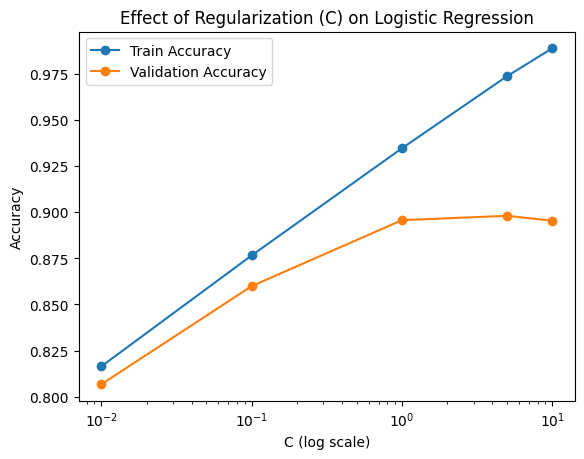

In [36]:
C_values = [0.01, 0.1, 1, 5, 10]
train_scores = []
val_scores = []

for C in C_values:
    lr = LogisticRegression(max_iter=2000, C=C)
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
        ('lr', lr)
    ])

    pipe.fit(X_train, y_train)

    train_scores.append(pipe.score(X_train, y_train))
    val_scores.append(pipe.score(X_test, y_test))  

plt.plot(C_values, train_scores, marker='o', label='Train Accuracy')
plt.plot(C_values, val_scores, marker='o', label='Validation Accuracy')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Accuracy')
plt.title('Effect of Regularization (C) on Logistic Regression')
plt.legend()
plt.show()

Aha! From this graph we can see that: 
- As C increases the model gets more complex and training accuracy keeps increasing (meaning this model is flexible).
- The **validation accuracy stops improving** and even slightly plateues after **C = 5** due to overfitting. 

It seems we hit the ceiling with TF-IDF and Logistic Regression, which is why tuning didn't give us much improvement.